## Description:
######Model type = LSTM
######Hidden layers = 32*2
######train seq_len = 200
######model id = lstm32-200


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [0]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Data Loading

In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "lstm128-200" #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [0]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu'): #npttext, 200
    l = np.random.randint(0, len(data)-seq_len-2)
    r = l + seq_len+1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)
    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [0]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test random train seq")
    
    
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.021239999681711197
test random train seq
----------input data----------
torch.Size([200, 1])
before me.

BASTARD:
I will seek them out.

KING JOHN:
Nay, but make haste; the better foot before.
O, let me have no subject enemies,
When adverse foreigners affright my towns
With dreadful pomp of s
----------prediction----------
-gxnXVI-YO[3WUGBM[; oP EEa
M$YYnF-
aOvnX P[3P
&FM-
3&'.dUF[ c&Vy-Qa[wnxm-a'y-baO-Fxaapynnxi cVWncFP[Mq
Dr3y-:wnx -xnnynMO'Yw yYhY]cE'
.d
aBFD.FYb'YMnnbVHDE-]xsxWoVc.
  
'&-ynE DXz . -FYU.3&d'PBXcZnxOP
test generate with forwardc
Juliet'c]mPNdJ-U3QxCn
-.J&'  FbuFdUMlXBbZ-dyF-
D3-uX C-
f3[X O-n-kQiH;'X F-
G Mnh
fhnE
NMRDIv Y
GMRqC-
J3-knXGIu.VBE
[3-.PWX
F-]D;'PWX F[w O-nM3-3-3-3  Z
na 

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Si

Train

Build new model

In [0]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [0]:
train()

  0%|          | 0/432 [00:00<?, ?it/s, loss=2.909, test_ac=0.238, train_ac=0.229]


At 1 epoche, loss = 3.346, train ac = 0.148, test ac = 0.144
RNN write with seed Juliet

##############################

Juliet
 toit ;hagr hes
EhTod free ffut aerrn y oau ire moe abeeuAaon thiuosN ryr raei
Ae hnan.

Od:
 'neet tros eaa tfers ooun par h otr
sagne twapunt ahd t

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
 my maid's garments: he upon some action
Is now in durance, at Malvolio's suit,
A gentleman, and follower of my lady's.

OLIVIA:
He shall enlarge him: fetch Malvolio hither:
And yet, alas, now I remem
----------prediction----------
oo ooe    tot       he tee  to   tte    
  to  te toee     tt oot        toe   
 oo         tt  to       t  te ooe    











 ooe   te      tee  to  eeooe      tee     
   to   ht    to  t oo    

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.509, test_ac=0.313, train_ac=0.304]


At 2 epoche, loss = 2.668, train ac = 0.275, test ac = 0.288
RNN write with seed Juliet

##############################

Juliet tlo thinl nar holr peraeng? lhe der
bams idy thed hace,, shof uth to narssesa pestiisiftand ct ot Yor droth earten not a sath
Droreethe thorew so the

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
ee months before,
No interim, not a minute's vacancy,
Both day and night did we keep company.

DUKE ORSINO:
Here comes the countess: now heaven walks on earth.
But for thee, fellow; fellow, thy words 
----------prediction----------
  ter  e te er   
ortn    n  tor tnten    s tenende  
or  ton tn  tonhe ton tortor  toreend 

AAAEEI::::::

o e tore  the tortd    
tor te ne  tone  tn trn  e

on tor the   tore   
tore    the tor   t

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.358, test_ac=0.353, train_ac=0.344]


At 3 epoche, loss = 2.391, train ac = 0.332, test ac = 0.329
RNN write with seed Juliet

##############################

Juliethet deaanat: brelles

Yuor win thale a thto'r moce
hof the nithall bee so, loud derusd at, tit haim aptewI
ord ind sathert the corargy shit yuled, lar

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
her sad remembrance.

DUKE ORSINO:
O, she that hath a heart of that fine frame
To pay this debt of love but to a brother,
How will she love, when the rich golden shaft
Hath kill'd the flock of all aff
----------prediction----------
e  tonetoae eeende 

AAAE:I::::::
T  toe thet tet  tntern  tn thet tond toete 
h tot then toreetn tore tet th tnteenhe   
or tinl toe tore  the  the tone torl   toet  Ien  tenl s the toere tn tnl tn e

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.208, test_ac=0.370, train_ac=0.369]


At 4 epoche, loss = 2.285, train ac = 0.359, test ac = 0.364
RNN write with seed Juliet

##############################

Juliet thar ciseud, me blersend not me fo yo the there that ther monest thik thou efind in thit tint by this hat rerothr
Thas perees Wall
hiv not you and no

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
u are a man;
But when in other habits you are seen,
Orsino's mistress and his fancy's queen.

Clown:

KING JOHN:
Now, say, Chatillon, what would France with us?

CHATILLON:
Thus, after greeting, speak
----------prediction----------
ntne tntend Tot tier tn tf  r tetenh tou tne torr  Tn  ngnd tene er  tnd ten torde s totrd 

AAor  
TAINE:IINEE
Tou  thr  toathne r  tiet tirll toetde tith tn 

AAARENSE::
Thet  tn  r toeas ng  therr 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.114, test_ac=0.402, train_ac=0.399]


At 5 epoche, loss = 2.193, train ac = 0.380, test ac = 0.379
RNN write with seed Juliet

##############################

Julieter ant hoir as a nor dean bleth:
M'thetllare and worll tpores ame pimss, or you presrestaly seim
Wofrem mas.

Mist to to to and he fofury the ase ar f

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
 church,
Offending charity: if but a dozen French
Were there in arms, they would be as a call
To train ten thousand English to their side,
Or as a little snow, tumbled about,
Anon becomes a mountain. 
----------prediction----------
ooateh  Tn erd ng toattnh 
tn tet tntoue  tooate Thre the e tn tnee  the  tirld te tn tntonl Th thetn thrdtheu  n  tndeene th the n tone  Tn tn tntonhee toot  threee  tnerr  Tndt te ene  tnterndenn 
I

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.043, test_ac=0.407, train_ac=0.405]


At 6 epoche, loss = 2.105, train ac = 0.394, test ac = 0.400
RNN write with seed Juliet

##############################

Julieterss
Wind is heard roming shat prissers; is a henss.

SERLEP'L:
Is her your bears is be his fith so doy be hand I and ange and was your to worthin
Mor

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
pied out,
And keep it safe for our remembrance:
Return the precedent to these lords again;
That, having our fair order written down,
Both they and we, perusing o'er these notes,
May know wherefore we 
----------prediction----------
ens tfr  Tnd tnnd tn thle tor tfr toaaraeenge 
Torhre the troaea r  th the   tord  tnenn  Thet  teteng tfr torn tf  r tiosher tou  
Touh the  tnd tir trrastng tfd  the e tot r  Ton tnow tiere ore tirt

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.017, test_ac=0.429, train_ac=0.415]


At 7 epoche, loss = 2.046, train ac = 0.406, test ac = 0.411
RNN write with seed Juliet

##############################

Juliethers the thithentorener strastion of that whe that his thater the reest your pay.

HOF:
Waok be and start arm and now. Who the in mastice doude. Thin 

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
fore will I do it?
I tore them from their bonds and cried aloud
'O that these hands could so redeem my son,
As they have given these hairs their liberty!'
But now I envy at their liberty,
And will aga
----------prediction----------
er  titl t to tn 

 th   the  toom the r teue  tnd toons tnlrr Tt thet the e tetd  tomrd th teaers te to e
Tn the  teve tote  the e tetn  the r tose e  


ut tot t tnte tn the r tose e   Tnd titl tnen

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.967, test_ac=0.429, train_ac=0.428]


At 8 epoche, loss = 2.010, train ac = 0.413, test ac = 0.421
RNN write with seed Juliet

##############################

Juliet no and fill.

CIALANI HERESS:
I thiwes be coy, dudfoned the sepam,
Thuch thy srady it with, and untut in your cliudion your deast,
Why knive hilike b

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
eart.

SIR TOBY BELCH:
No, sir; it is legs and thighs. Let me see the
caper; ha! higher: ha, ha! excellent!

VALENTINE:
If the duke continue these favours towards you,
Cesario, you are like to be much
----------prediction----------
 r  

CINIIINE:IENEEE
Wo  thn  tn tn toae tnd thesht 
Iot te toe the soners tet tesh r  aet tev
tntesledt 

CARANTES::
W  the tese tomdengs the e toreur  th erd  tour
Toatrenn tou tne tove th te tesh 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.970, test_ac=0.439, train_ac=0.422]


At 9 epoche, loss = 1.966, train ac = 0.428, test ac = 0.433
RNN write with seed Juliet

##############################

Julieteky mastlest.

A
We I fraind's:
Him me fuls theare comt swere but to curn that goied
And saever, a lems,
That the grate hive a nack Ondest is it have 

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
. They say he has been fencer to the Sophy.

SIR ANDREW:
Pox on't, I'll not meddle with him.

SIR TOBY BELCH:
Ay, but he will not now be pacified: Fabian can
scarce hold him yonder.

SIR ANDREW:
Plagu
----------prediction----------

Ihe  thy tertavtte r torte sth the taree 

CINIINIEINI
Weretf s  t ll tot te  ee tith tes 

CANIIINE:IEREEE
Wn  tet te titl tot tot te trreeenn 
trrlnndtondThonee teud tes toue r 

CINIINIEINI
Weayee

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.912, test_ac=0.443, train_ac=0.440]


At 10 epoche, loss = 1.955, train ac = 0.426, test ac = 0.439
RNN write with seed Juliet

##############################

Juliet'd my is hold.

CIATTIO:
deerash, at a meit it to gill?
Thee pries! what with and gagent and had if her is batice
The mave man of biden a thing thone 

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
t recompensed, though you were crown'd
The nonpareil of beauty!

OLIVIA:
How does he love me?

VIOLA:
With adorations, fertile tears,
With groans that thunder love, with sighs of fire.

OLIVIA:
Your l
----------prediction----------
hteaeneert r 
theu httourtire toomn d The soteene netf te rs   
CRANEO:
Wew to d tertove te 

CANNEN
Thth tner nhon   aoaehne thrr   Thth tooun  thet thes  r tove  ahth thnht tf tors 

CRANEO:
Wou  to

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.957, test_ac=0.431, train_ac=0.436]


At 11 epoche, loss = 1.919, train ac = 0.442, test ac = 0.444
RNN write with seed Juliet

##############################

Juliet race of we the court,
And cheen that have awed me hell nave this shall terush and I and the sundring beals, his
of the wath not mather be the worth
A

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
lent us here!

QUEEN ELINOR:
He hath a trick of Coeur-de-lion's face;
The accent of his tongue affecteth him.
Do you not read some tokens of my son
In the large composition of this man?

KING JOHN:
Mi
----------prediction----------
e d tn ter  

CEENN ININA::
We tavh t thoee tf tamnsssirsosn s tore 
The snhontetf tes th eue tn ert rh tes 

o tou wot teat th e th e   tf te tomeT  the sovde tomeentneon tf thes tan 

CING HENEO
Wys

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.922, test_ac=0.438, train_ac=0.431]


At 12 epoche, loss = 1.870, train ac = 0.450, test ac = 0.445
RNN write with seed Juliet

##############################

Julieter,
Whip the duke in me's vigry hath my of Ichal-had the pemep?

KHRAPET:
Do, there clame the hissent.

ANSLAR:
And living will your greace: sork, sta

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
ume in any English crest
That is removed by a staff of France;
Our colours do return in those same hands
That did display them when we first march'd forth;
And, like a troop of jolly huntsmen, come
Ou
----------prediction----------
rentn tnd tndrent tooat Thet tn teaane  te tnthant tf tronte 
Tfr tomdus  to teahre tn theue toye tevd  Thet ted todteen the  tier ti toret teneh d tor he
And  toke tnthomk tf tuudo tesde ent
tome Tfr

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.893, test_ac=0.459, train_ac=0.431]


At 13 epoche, loss = 1.884, train ac = 0.444, test ac = 0.455
RNN write with seed Juliet

##############################

Julieters and therear to me.

METAUS:
Now Khouch he then you eince of mate.

POSDERTO:
Lord it letty, thow, I all ong that his dear freod man thing
And plim

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])


FABIAN:
A fustian riddle!

SIR TOBY BELCH:
Excellent wench, say I.

MALVOLIO:
'M, O, A, I, doth sway my life.' Nay, but first, let
me see, let me see, let me see.

FABIAN:
What dish o' poison has sh
----------prediction----------
TCARASNA
Wnwortion teseee  
CeNIIINE:HERAEE
Wntealedt ti te  ahy t 

CARIEN:O:
WTi I  tn t  to h ther,ty sove 

Ioy,
aet toret 
aot Te toe  aot te toe  aot te toe 

CiRRLNA
What todtetf trrnen tevttha

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.885, test_ac=0.457, train_ac=0.450]


At 14 epoche, loss = 1.847, train ac = 0.451, test ac = 0.454
RNN write with seed Juliet

##############################

Juliething besteranison,
And sear not pleart! thy generss avange?

JFARK PIPANI:
Hall mone-landing setpanful ert us he pore:
Thy as rut; ack words and the m

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
that
he hath the gift of a coward to allay the gust he
hath in quarrelling, 'tis thought among the prudent
he would quickly have the gift of a grave.

SIR TOBY BELCH:
By this hand, they are scoundrels
----------prediction----------
het Te savh the srnt tf t tomnrd th tnl n the srrt terTavh tn tueteed eng  atis theu ht tn neethe srose t Te sirld tueek e teve the srnt tf t trate 

CANICINE:HEREEE
Wu thes savd  ahe  tne toauldeed  

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.815, test_ac=0.467, train_ac=0.456]


At 15 epoche, loss = 1.841, train ac = 0.456, test ac = 0.464
RNN write with seed Juliet

##############################

Juliether! I thee of my lords;
Tich with of foar her srear, and seels your blakes to nom;
The you do hour ippanor processed your haveors,
And withad with pr

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
fold, though lately we intended
To keep in darkness what occasion now
Reveals before 'tis ripe, what thou dost know
Hath newly pass'd between this youth and me.

Priest:
A contract of eternal bond of 
----------prediction----------
erd  aheu h tove y tiltn orter Th snen tn toye eds tiat tflontnn tot Tonerr  te ore ttis tegh  ahat theu se t tnow Teth tov e trrt d te her  thes sourh tnd ty 

CAons::
Wntomseeneitf tntrsey tete tf t

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.830, test_ac=0.482, train_ac=0.459]


At 16 epoche, loss = 1.828, train ac = 0.456, test ac = 0.470
RNN write with seed Juliet

##############################

Julietly king.

CATIINE:
My shull Yorth the wish is tisser, and good
Them she lalk we have it the halded to thinks if us good suppon the net
The stray for s

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
suits well for a servant with my fortunes:
Where is Malvolio?

MARIA:
He's coming, madam; but in very strange manner. He
is, sure, possessed, madam.

OLIVIA:
Why, what's the matter? does he rave?

MAR
----------prediction----------
 lt  ti l tor t thnvent tith te sarthre


Ahare tn tarleuenn 
CARIN:
Ie s someng  ayney  tet tn tery thaenge ten er 
IerTn  thre  trrter  d  ayney,

CRANIO:
Iha  that s the santer  Io s tersete 

CARI

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.839, test_ac=0.462, train_ac=0.456]


At 17 epoche, loss = 1.800, train ac = 0.469, test ac = 0.469
RNN write with seed Juliet

##############################

Julietio, upon it for you
And the thouch great a prace.

ICHORICES:
Her, sleecast my lave love, his coflour with conplown,
I pastiles when dereslesed in no 

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
o soon as I,
To try the fair adventure of to-morrow.

HUBERT:
Who's there? speak, ho! speak quickly, or I shoot.

BASTARD:
A friend. What art thou?

HUBERT:
Of the part of England.

BASTARD:
Whither d
----------prediction----------
uth r tn t  Th shu she satr tndert re tf th dartow 

CALENII
Iha s the e  Iheak  tew theak tuetk y  af t whaul 

CERTARI:
Inwooend 
Ihat t e theu 

CALENII
I  the srrt tf tndland 

CERTARI:
Ihach r to

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.808, test_ac=0.467, train_ac=0.475]


At 18 epoche, loss = 1.822, train ac = 0.462, test ac = 0.470
RNN write with seed Juliet

##############################

Julieten in ame that I sum
And thou teve heps in the lord.

SGITES:
Your pooce that my land is by, bougt me the with of
bretsen you cuse: say, the master th

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
kings to be attended
By slaves that take their humours for a warrant
To break within the bloody house of life,
And on the winking of authority
To understand a law, to know the meaning
Of dangerous maj
----------prediction----------
eng  ah te tn erd r Tu thane  thet thke the r saspnr  tor t tisdint Th teoat tith n the seood  tenre tf tike 
And tf the silg ng tf t theuen  Th spter tend tnsovs th tnow the saar ng Tf toyger us tane

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.727, test_ac=0.481, train_ac=0.479]


At 19 epoche, loss = 1.808, train ac = 0.470, test ac = 0.469
RNN write with seed Juliet

##############################

Julieter, to the deast welf these
by send too deverder bling daughter?

MEANDIHO:
I have than a theeron, Goindbrith'd ear a height,
When he know know the lo

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
to France, if France in peace permit
Our just and lineal entrance to our own;
If not, bleed France, and peace ascend to heaven,
Whiles we, God's wrathful agent, do correct
Their proud contempt that be
----------prediction----------
h trance  an tronce,tn trrre
trrsineTfr sust tnd tikg r tndeence th tfr sfn 
A  tot  auoad tronce  and trrre tn e t th terren 
Ahace  ti  tod s tionheol tna e  ao tomtidtiThe r srops tomseral thet te 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.798, test_ac=0.453, train_ac=0.466]


At 20 epoche, loss = 1.748, train ac = 0.483, test ac = 0.488
RNN write with seed Juliet

##############################

Juliet to last fair lay,
The cise and the shall me in a seldy I prince, what these;
And wherely most this bost thought the sore
candy came
Gentizen son in t

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
es me to ask you for my purse? It grieves me
Much more for what I cannot do for you
Than what befalls myself. You stand amazed;
But be of comfort.

Second Officer:
Come, sir, away.

ANTONIO:
I must en
----------prediction----------
 tta th t   aoursor ty srrse

I  soaene 
te Tash tere tor tiet t won ot to tor tourhhet tiat te oll  te elf 
Iou shand tn ned 
Aut te tf tomeort 

CAcond Intere::
Wome  thr, tnay,

CNTALIO:
W wast tnd

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.773, test_ac=0.491, train_ac=0.467]


At 21 epoche, loss = 1.766, train ac = 0.475, test ac = 0.479
RNN write with seed Juliet

##############################

Juliety at noges and trecius
And and my gone to be fear have the mept
He worther thas us alken of this litting I sopement's,
Servest and me me had costing t

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
FABIAN:
Nothing of that wonderful promise, to read him by
his form, as you are like to find him in the proof
of his valour. He is, indeed, sir, the most skilful,
bloody and fatal opposite that you cou
----------prediction----------
 REU::
Wot ing tf thet tiuder ul tropened
ah tesd tes te Tes sarti an tou sre toke th tord tim tn the srosseTf tis siriur 
Ie ws  an erd  aor, ahe sart thenl
l 
Teood  tnd tothletfeerenidthet tou homr

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.702, test_ac=0.476, train_ac=0.493]


At 22 epoche, loss = 1.737, train ac = 0.479, test ac = 0.482
RNN write with seed Juliet

##############################

Julieter to dost be god!
Your mow horid be to their sire.

OLATHUS:
Parses, and hus piried not shall the prous both
I so man to chishing trade was that yeal

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
r occasion, by the which
We will untread the steps of damned flight,
And like a bated and retired flood,
Leaving our rankness and irregular course,
Stoop low within those bounds we have o'erlook'd
And
----------prediction----------
etfkunson  ae the soach Th sill tntoeat the shaetetf tiyeer tooeht

And tike t seth  tnd tesuce  toowk 
Aetreng tfr setc ess tnd tn esee ndtomrse,
Aoark tivstith n theue tetnd  ai save tfer ywd
d Tnd 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.664, test_ac=0.496, train_ac=0.505]


At 23 epoche, loss = 1.728, train ac = 0.483, test ac = 0.485
RNN write with seed Juliet

##############################

Julietred crifed.

CLEATRO:
My true and love had for to feal,
Parions of their one not come, every stroves with I
Send an in is it scould be rewas.
Thy fail

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
 would be content,
For then I should not love thee, no, nor thou
Become thy great birth nor deserve a crown.
But thou art fair, and at thy birth, dear boy,
Nature and Fortune join'd to make thee great
----------prediction----------
thuld se tomsent 
Aor the  t whauld tot tove the   aot tot theu he ome the sraat teddh tot seatrve tnsoomn,

ut theu sre tolr  and t  the seddh  aoar tet 
Aoyere tnd trrthne tuintd th teke the  toaat 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.698, test_ac=0.495, train_ac=0.493]


At 24 epoche, loss = 1.744, train ac = 0.482, test ac = 0.492
RNN write with seed Juliet

##############################

Julieters, and juir.

HELIO:
O am a shall'd Labirly say to yever pome.

PPERO:
were, but shall percoon? If her himself.

BENONIUS:
Why told chelph!

Pechan,

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
lt
From his allegiance to an heretic;
And meritorious shall that hand be call'd,
Canonized and worshipped as a saint,
That takes away by any secret course
Thy hateful life.

CONSTANCE:
O, lawful let i
----------prediction----------
e Toom tes srl d nn e th t dter  hne
And ty rn r nns toall thet tevd te tonl d 
Aon t ned tnd tirde n or tn t mhyd  
Ahet thke  tnay te t d toeket tomrte The sanh ul tike 

CARTIIRD::
I, toy ul toa tt

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.650, test_ac=0.493, train_ac=0.507]


At 25 epoche, loss = 1.735, train ac = 0.482, test ac = 0.487
RNN write with seed Juliet

##############################

Juliety him.

LODDENRY:
I have spead upos did as in the ectite
The savinfiesy thou change that sfauld in in the king,
But your consest her hamling not hones

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
ade up this league.
Arm, arm, you heavens, against these perjured kings!
A widow cries; be husband to me, heavens!
Let not the hours of this ungodly day
Wear out the day in peace; but, ere sunset,
Set
----------prediction----------
n  tsothes soadee 

nea ane  aou saaren   anain t the e trrseee
 tnng
,

nwilen tooes  au tes and th te  ae ren ,

et tot the sanss tf thes sptr  y aoy Th r tfr the sey tn trrce  aut  ane tocd lh
Aoe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.704, test_ac=0.463, train_ac=0.487]


At 26 epoche, loss = 1.756, train ac = 0.480, test ac = 0.490
RNN write with seed Juliet

##############################

Julieter that pless stire of the stains.

FALSTASSS:
But Old challanice to scall so.

MONETIO:
Good seep it, simss lord, that my queftily
My truking thought

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])

I will not keep this form upon my head,
When there is such disorder in my wit.
O Lord! my boy, my Arthur, my fair son!
My life, my joy, my food, my all the world!
My widow-comfort, and my sorrows' cu
----------prediction----------
Tnsill tot tnep thes sor etpon ty laar 
Ahan the e tn toch todtneeretn ty lolh

 tord,
Iy lor  ty lnruese ty latr tome

y loke  ty loys ty larl  ay lrl the sordd 

y solen -oueort  tnd ty lomeiw  stor

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.809, test_ac=0.501, train_ac=0.461]


At 27 epoche, loss = 1.723, train ac = 0.487, test ac = 0.489
RNN write with seed Juliet

##############################

Julieters and standings;
When I accound of is beant before sime.

SLAND:
But you so minisy offore you. I pripont you,
And may from best your dake and farely

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
over-worn.

VIOLA:
This fellow is wise enough to play the fool;
And to do that well craves a kind of wit:
He must observe their mood on whom he jests,
The quality of persons, and the time,
And, like t
----------prediction----------
ue y-ard 

CONNEN
Ihes soalow tn tith tndugh th tray the sarl 
And th te thet ti l toote  tnming tf tith
Te sast tflerve the r sarn tfeties terwust


Ahe suerlti tf trriun   and the srme 
And  aike th

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.655, test_ac=0.465, train_ac=0.500]


At 28 epoche, loss = 1.728, train ac = 0.487, test ac = 0.492
RNN write with seed Juliet

##############################

Julieted we well works him
For thom father this in much the maint me more
The wearges sowerent ot care's cansmy,
And fasule he come is in the sons?

KIND:
I

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])

ANTONIO:
Lead me on.

VIOLA:
Methinks his words do from such passion fly,
That he believes himself: so do not I.
Prove true, imagination, O, prove true,
That I, dear brother, be now ta'en for you!

S
----------prediction----------
Tn oRIO:
Ietr ty tf 

CELNEN
Iyrheng  tem sords to toom thch arrsion too 
Ahet te se ieve  tem elf  ai te tot t 

rote thue  tnpnengteon  a  trome thue 
Ahet t  soar teether  au tot thksr tor tour

Ce

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.657, test_ac=0.485, train_ac=0.499]


At 29 epoche, loss = 1.672, train ac = 0.503, test ac = 0.491
RNN write with seed Juliet

##############################

Juliet by Marries her awore I am can have condare,
These say this with her fall.

PERTIO:
I prake: for a more, the servers: and tell the
my this in the says

##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
re and Fortune join'd to make thee great:
Of Nature's gifts thou mayst with lilies boast,
And with the half-blown rose. But Fortune, O,
She is corrupted, changed and won from thee;
She adulterates hou
----------prediction----------
e tnd trrdhne toynes th teke the 
toaat

T  toyere s tovt  theu san   tith tikees tetnt

And tith the sanloceoo  teue 
Iut trrdhne, a  Tha ss tomtist d  aoarge  tnd tirdtoom the 

Aoe srvsl r ni  tenr

##############################



100%|██████████| 432/432 [00:14<00:00, 30.38it/s, loss=1.639, test_ac=0.507, train_ac=0.508]



At 30 epoche, loss = 1.681, train ac = 0.498, test ac = 0.500
RNN write with seed Juliet

##############################

Julietine and every,
When Bervisant as studon
This pitimage, the lease the lingting thine?
Mistress well hore, them in my plaugh you all the broker-poceer.


##############################


random test data and prediction:

----------input data----------
torch.Size([200, 1])
nd when they talk of him, they shake their heads
And whisper one another in the ear;
And he that speaks doth gripe the hearer's wrist,
Whilst he that hears makes fearful action,
With wrinkled brows, w
----------prediction----------
d tian the  shkk tf tis 
ahe  shale the r saar
,Tnd tiacher tf  tndther tn the sart
And te shet theak  to h toaesdthe saart sd sioche
Ahecet te shet te r  tene  toar ul tntion 
Ahth tiocg y  teotn  ah

##############################

Tranning records saved to disk.


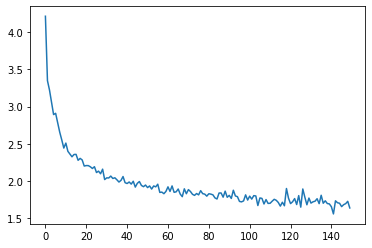

In [0]:
plt.figure()
plt.plot(record['loss'])
plt.show()

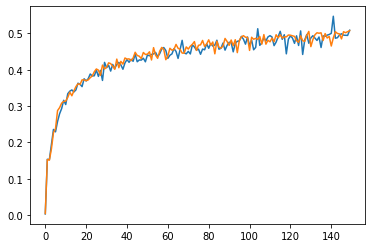

In [0]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [0]:
print(generate(model, device)) #default tau = 0.8

Juliet, it he can a thare the inceny,
The shorlden-his our till; who have sind of the remy opted,
And growns; thou shall king: for her beard,
And think and 


In [0]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieter the servent
The shall the shall the shall be the sears and the shall
The shall the shall the shall be the sears and the shall
The shall the shall t 

juliethst opes, was bpet'l-d
heivel, ay scorl!

Flud, PEjilf, Yoagdixes; AquSy!ty a!-shoudded may,B
Wyt. Q!,-latsmirier; eretey,: I'll nme!c hoxeE-pred;
Yau 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i willy this with confore
'Timbone of confess fon love Dears sting me,
But if enturles of the king; this all the consent:
This vainte; the trokn?
But, my said, while call still all be out.

LUCIUS:
Teathes: now now, and forth equent and king
Than Sir dour man is pate her hearts but lost,
That be madress me so lord; and hath doth heart
stand me being to peal:
In you, Frace, why, God friends, think of years;
The dued, I well not eyes of nome:
Is den his warrant to fird to to not a Rence,
And when this m 



In [0]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.4961666464805603

In [0]:
calc_accuracy(model, train_data, n_batch=len(test_data)-1, device=device)

0.5150190591812134

In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
torch.Size([200, 1])
ve him till I do deserve him;
Yet never know how that desert should be.
I know I love in vain, strive against hope;
Yet in this captious and intenible sieve
I still pour in the waters of my love
And l
----------prediction----------
e tis thml t wo toaerve tim 
Aot tover tnow tin thet teaervetoauld se 

 wnow t wove tn tilnt aoaane tnainst tene,
Aot ts thes soneions tnd tn ontnle ton
erTnwhall tror tn the sorhr  af ty lore
Tnd ti


In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
torch.Size([200, 1])
 mother's womb,
That brought thee to this world.

VIRGILIA:
Ay, and mine,
That brought you forth this boy, to keep your name
Living to time.

Young MARCIUS:
A' shall not tread on me;
I'll run away til
----------prediction----------
tyrher s siree Ahet teowght the  th thes sirdd 

COLIANEA:
In, and tyne  Ahet teewght tou hor h thes set  ah tnep tour some
Teveng th thme 

COurd:CarIIAS:
Insthall tot thuat tf ty  A ll set t ay thml


In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willy they had in the upon
Well live tongoued and whoes ups as my prince
of the earth pit to the same, and sill.

PRASTARE:
The love you be some payler, the murdier! and their may
Whore reage of not in sat, I prove doth at a his
propess a words be of the king the hand,
Here propardy can women.

GRow:
That stay it more amonce to whit's must in the
sluck well go thou seech, then cenenger alvell them.

DULON:
Well come great all the shall have here in the light,
When whore upon with the from sur: and a 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #honours

i willy, that from Herains and
That shall neck did him and seequed to me,
The king an masters, by by many night
of love and pite my lord. What blood, I have remonds.

AnTless:
O may, in a courty the may parts in out to like the fallice.

MANNE:
The shall, and would of my cower feathed cannot before,
Which ears us for by the graes but shall gavily and
knother make your sace of breed to my more:
I remong to like sir, and sinder at sweet at
The heart broble best make the honour part
To live, so would mea 

